In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import torch

# Pastikan CUDA tersedia
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Pilih GPU pertama (NVIDIA)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using GPU: NVIDIA GeForce GTX 1650


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Transformasi data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split data
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Dataloader
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, kernel_size=3, pooling='max', num_classes=10):
        super(CNN, self).__init__()
        self.pooling = pooling
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=kernel_size//2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        if pooling == 'max':
            self.pool = nn.MaxPool2d(2, 2)
        elif pooling == 'avg':
            self.pool = nn.AvgPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
from torch.optim import SGD, RMSprop, Adam
from torch.optim.lr_scheduler import StepLR

def train_model(model, optimizer, epochs, early_stop_patience, lr_scheduler, device):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1) if lr_scheduler else None
    
    best_val_loss = float('inf')
    patience = 0

    # Untuk menyimpan riwayat training
    history = {'train_loss': [], 'val_loss': []}

    print(f"{'Epoch':<10}{'Train Loss':<15}{'Val Loss':<15}{'Learning Rate':<15}")
    print("=" * 50)

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            if patience >= early_stop_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Learning rate scheduling
        current_lr = optimizer.param_groups[0]['lr']
        if scheduler:
            scheduler.step()

        # Print progress
        print(f"{epoch+1:<10}{train_loss:<15.6f}{val_loss:<15.6f}{current_lr:<15.6f}")
    
    return history


In [9]:
import itertools
import pandas as pd

# Hyperparameter setup
kernel_sizes = [3, 5, 7]
pooling_types = ['max', 'avg']
optimizers = {'SGD': SGD, 'RMSProp': RMSprop, 'Adam': Adam}
epochs_list = [5, 50, 100, 250, 350]

results = []

# Loop eksperimen
for kernel_size, pooling, (opt_name, opt_fn), epochs in itertools.product(
    kernel_sizes, pooling_types, optimizers.items(), epochs_list):
    
    print(f"\nRunning experiment: Kernel Size={kernel_size}, Pooling={pooling}, Optimizer={opt_name}, Epochs={epochs}")
    model = CNN(kernel_size=kernel_size, pooling=pooling)
    optimizer = opt_fn(model.parameters(), lr=0.01)
    best_val_loss = train_model(model, optimizer, epochs, early_stop_patience=10, lr_scheduler=True, device=device)
    
    # Log hasil
    results.append({
        'Kernel Size': kernel_size,
        'Pooling': pooling,
        'Optimizer': opt_name,
        'Epochs': epochs,
        'Best Val Loss': best_val_loss
    })

# Simpan hasil ke CSV
import pandas as pd
df = pd.DataFrame(results)
df.to_csv('experiment_results.csv', index=False)




Running experiment: Kernel Size=3, Pooling=max, Optimizer=SGD, Epochs=5
Epoch     Train Loss     Val Loss       Learning Rate  
1         2.085313       1.846693       0.010000       
2         1.714724       1.605795       0.010000       
3         1.532832       1.490319       0.010000       
4         1.426621       1.391420       0.010000       
5         1.341889       1.352678       0.010000       

Running experiment: Kernel Size=3, Pooling=max, Optimizer=SGD, Epochs=50
Epoch     Train Loss     Val Loss       Learning Rate  
1         2.095375       1.870570       0.010000       
2         1.759019       1.665967       0.010000       
3         1.561691       1.526649       0.010000       
4         1.436652       1.425704       0.010000       
5         1.350329       1.336158       0.010000       
6         1.282862       1.287044       0.010000       
7         1.225305       1.259801       0.010000       
8         1.175173       1.211330       0.010000       
9         1.1

In [10]:
import matplotlib.pyplot as plt

# Visualize training history
def plot_training_history(history, title="Training and Validation Loss"):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='orange')
    plt.title(title, fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()


Epoch     Train Loss     Val Loss       Learning Rate  
1         2.303556       2.303743       0.010000       
2         2.303693       2.302739       0.010000       
3         2.303655       2.304926       0.010000       
4         2.303425       2.303469       0.010000       
5         2.303678       2.303280       0.010000       
6         2.303512       2.303968       0.010000       
7         2.303514       2.304083       0.010000       
8         2.303421       2.304421       0.010000       
9         2.303630       2.303165       0.010000       
10        2.303485       2.302850       0.010000       
11        2.303617       2.304052       0.010000       
Early stopping at epoch 12


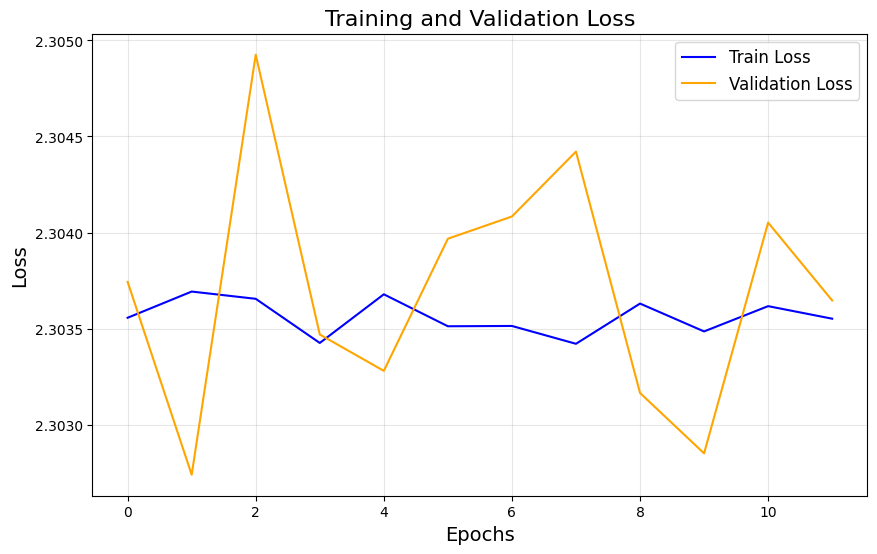

In [11]:
# Panggil fungsi train_model
history = train_model(model, optimizer, epochs=50, early_stop_patience=10, lr_scheduler=True, device=device)

# Plot hasilnya
plot_training_history(history)


In [14]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# Lokasi file hasil eksperimen
results_path = 'experiment_results.csv'

# Baca file CSV
df = pd.read_csv(results_path)

# Tambahkan kolom 'Best Val Accuracy' berdasarkan 'Best Val Loss'
def calculate_accuracy_from_loss(val_loss):
    val_loss_dict = ast.literal_eval(val_loss)  # Konversi string menjadi dictionary
    val_loss_list = val_loss_dict['val_loss']
    best_loss = min(val_loss_list)
    # Konversi loss ke akurasi (asumsi: akurasi = 1 - normalized_loss)
    best_accuracy = 1 - best_loss
    return best_accuracy

df['Best Val Accuracy'] = df['Best Val Loss'].apply(calculate_accuracy_from_loss)

# Urutkan berdasarkan akurasi terbaik
top_10_results = df.sort_values(by='Best Val Accuracy', ascending=False).head(10)

# Tampilkan DataFrame hasil
print(top_10_results[['Kernel Size', 'Pooling', 'Optimizer', 'Epochs', 'Best Val Accuracy']])


    Kernel Size Pooling Optimizer  Epochs  Best Val Accuracy
34            5     max       SGD     350           0.115198
61            7     max       SGD      50           0.114594
31            5     max       SGD      50           0.107082
32            5     max       SGD     100           0.104410
64            7     max       SGD     350           0.099890
62            7     max       SGD     100           0.097994
33            5     max       SGD     250           0.093957
63            7     max       SGD     250           0.090622
3             3     max       SGD     250           0.078070
1             3     max       SGD      50           0.072847


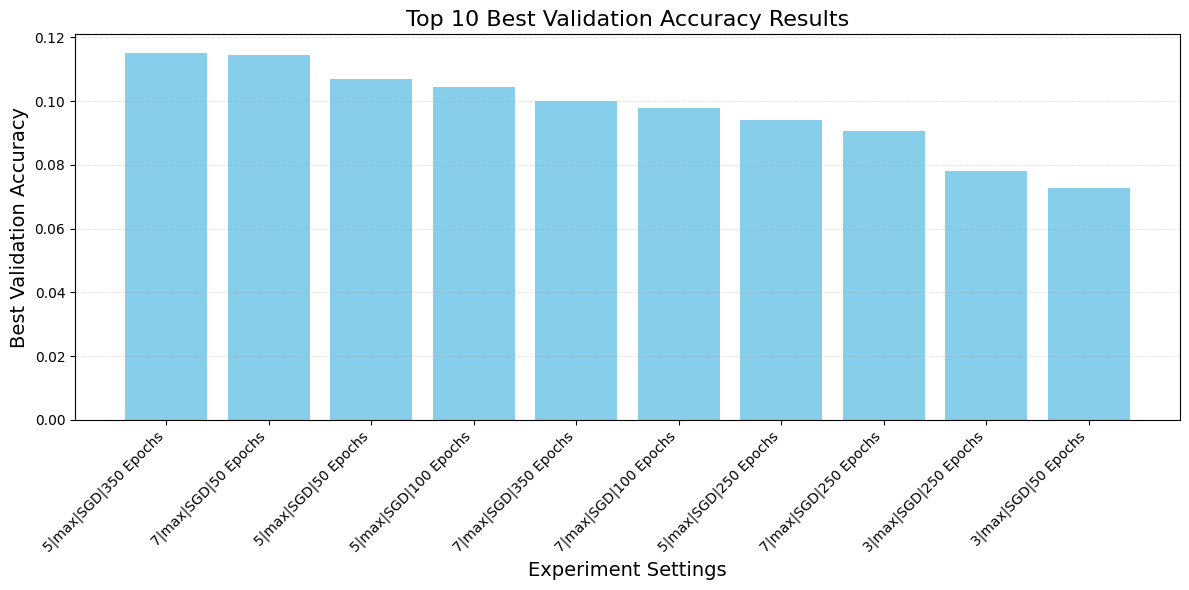

In [15]:
# Plot barplot
plt.figure(figsize=(12, 6))
bar_labels = [
    f"{row['Kernel Size']}|{row['Pooling']}|{row['Optimizer']}|{row['Epochs']} Epochs"
    for _, row in top_10_results.iterrows()
]
plt.bar(bar_labels, top_10_results['Best Val Accuracy'], color='skyblue')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Experiment Settings', fontsize=14)
plt.ylabel('Best Validation Accuracy', fontsize=14)
plt.title('Top 10 Best Validation Accuracy Results', fontsize=16)
plt.grid(alpha=0.3, linestyle='--', axis='y')
plt.tight_layout()
plt.show()